In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipynbname
import os

# 1. Import original dataframe and update data

The initial data collection was done in November 2024; it included data from different sources:

- Register of Buildings and Dwellings (https://www.housing-stat.ch/it/madd/public.html#scaricare_i_dati) --> has data of building properties and heating technology
- Electricity production plants (https://www.geocat.ch/geonetwork/srv/ita/catalog.search#/metadata/e5a00bdb-5022-4856-ad4a-d1afe7bf38b0) --> has the data related to all production plants actually installed in Switzerland
- Suitability of roofs for the use of solar energy (https://www.geocat.ch/geonetwork/srv/eng/catalog.search#/metadata/b614de5c-2f12-4355-b2c9-7aef2c363ad6)
- Cadastral data (https://www.geocat.ch/geonetwork/srv/eng/catalog.search#/metadata/a3c0f7fb-1be0-4385-9c54-33b65ae3e1ae) --> has the shapefiles of each infrastructure in Switzerland. These data is not available for all the Cantons.

The output of the first data collection is one unique dataframe that contains for each residential building in Switzerland the data related to its properties, heating technology, PV plant presence and shape (for the Cantons with open cadastral data available).
In order to have more updated data, the original geodataframe (here named 'gdf_input') is updated with data from the first two databases (while the data on solar potential didn't change over the last year).

In [81]:
notebook_path = ipynbname.path()
notebook_dir = os.path.dirname(notebook_path)

gdf_file = '/data/gdf_input.gpkg'

gdf_raw = gpd.read_file(notebook_dir + gdf_file)
gdf = gdf_raw.to_crs(epsg=2056)

In [82]:
gdf = gdf.drop(columns=['GDEKT', 'GGDENAME', 'GKODE', 'GKODN', 'GSTAT', 'GKAT', 'GKLAS', 'GBAUJ', 'GBAUP', 'GAREA', 'GASTW', 'GANZWHG', 'GEBF', 'GWAERZH1', 'GENH1', 'GWAERSCEH1', 'GWAERDATH1', 'GWAERZW1', 'GENW1', 'GWAERSCEW1', 'BeginningOfOperation', 'TotalPower'])
gdf['EGID'] = gdf['EGID'].astype(int)

In [83]:
RBD_file = '/data/gebaeude_batiment_edificio.csv'

df_RBD = pd.read_csv(notebook_dir + RBD_file, sep='\t', low_memory=True)
df_RBD = df_RBD.drop(columns=['GGDENR', 'EGRID', 'LGBKR', 'LPARZ', 'LPARZSX', 'LTYP', 'GEBNR', 'GBEZ', 'GKSCE', 'GBAUM', 'GABBJ', 'GVOL', 'GVOLNORM', 'GVOLSCE', 'GAZZI', 'GSCHUTZR', 'GWAERSCEH2', 'GWAERDATH2', 'GWAERDATW1', 'GWAERZW2', 'GENW2', 'GWAERSCEW2', 'GWAERDATW2', 'GEXPDAT'])

C:\Users\matteo.palucci\AppData\Local\Temp\ipykernel_25480\973953882.py:3: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_RBD = pd.read_csv(notebook_dir + RBD_file, sep='\t', low_memory=True)


In [84]:
gdf_merge = gdf.merge(df_RBD, how='left', on='EGID')

In [85]:
plants_file = '/data/ch.bfe.elektrizitaetsproduktionsanlagen.gpkg'

gdf_PV = gpd.read_file(notebook_dir + plants_file, layer='ElectricityProductionPlant')
gdf_PV = gdf_PV.to_crs(epsg=2056)

gdf_PV = gdf_PV.loc[gdf_PV['SubCategory'] == 'subcat_2']
gdf_PV = gdf_PV.drop(columns=['Address', 'PostCode', 'Municipality', 'Canton', 'InitialPower', 'MainCategory', 'SubCategory', 'PlantCategory'])

In [86]:
cantons_with_cadastral_data = ['GR', 'BE','VS', 'TI', 'SG', 'ZH', 'FR', 'AG', 'UR', 'TG', 'SZ', 'SO', 'GL', 'BL', 'GE', 'SH', 'ZG', 'AI', 'BS']

In [87]:
gdf_merge_cad = gdf_merge[gdf_merge['GDEKT'].isin(cantons_with_cadastral_data)].copy()
gdf_merge_PV_1 = gpd.sjoin(gdf_merge_cad, gdf_PV, how="left", predicate='intersects')

In [88]:
gdf_merge_PV_1 = gdf_merge_PV_1.drop_duplicates(subset='EGID')
gdf_merge_PV_1 = gdf_merge_PV_1.drop(columns=['index_right'])

In [89]:
print(len(gdf_merge_cad), '----> Buildings in the initial data')
print(len(gdf_PV), '----> PV plants')
print(len(gdf_merge_PV_1), '----> Buildings in the resulting joined gdf')

gdf_merge_PV_1['TotalPower'] = gdf_merge_PV_1['TotalPower'].fillna(0)
gdf_merge_PV_1['Is_First'] = gdf_merge_PV_1.groupby('xtf_id').cumcount() == 0
gdf_merge_PV_1.loc[~gdf_merge_PV_1['Is_First'], 'TotalPower'] = 0
gdf_merge_PV_1 = gdf_merge_PV_1.drop(columns=['Is_First'])

print(len(gdf_merge_PV_1.loc[~gdf_merge_PV_1['TotalPower'].isin([0])]), '----> Number of buildings with PV after filtering for PV assigned to different buildings')

1433255 ----> Buildings in the initial data
306144 ----> PV plants
1433255 ----> Buildings in the resulting joined gdf
183584 ----> Number of buildings with PV after filtering for PV assigned to different buildings


In [90]:
gdf_merge_cad_no = gdf_merge[~gdf_merge['GDEKT'].isin(cantons_with_cadastral_data)].copy()

In [91]:
gdf_bld_PV_10 = gpd.sjoin_nearest(gdf_merge_cad_no, gdf_PV, how='left', distance_col='distance', max_distance=10)
gdf_bld_PV_10 = gdf_bld_PV_10.drop(columns=['index_right', 'distance'])
print(len(gdf_merge_cad_no), '----> Number of initial buildings')
print(len(gdf_bld_PV_10), '----> Number of buildings after merging with PV data')
print(len(gdf_bld_PV_10.loc[~gdf_bld_PV_10['TotalPower'].isna()]), '----> Number buildings with PV')

gdf_bld_PV_10['TotalPower'] = gdf_bld_PV_10['TotalPower'].fillna(0)
gdf_bld_PV_10 = gdf_bld_PV_10.drop_duplicates(subset='EGID')
print(len(gdf_bld_PV_10), '----> Number of buildings after eliminating EGID duplicates')

gdf_bld_PV_10['Is_First'] = gdf_bld_PV_10.groupby('xtf_id').cumcount() == 0
gdf_bld_PV_10.loc[~gdf_bld_PV_10['Is_First'], 'TotalPower'] = 0
gdf_bld_PV_10 = gdf_bld_PV_10.drop(columns=['Is_First'])

print(len(gdf_bld_PV_10.loc[~gdf_bld_PV_10['TotalPower'].isin([0])]), '----> Number of buildings with PV after filtering for PV assigned to different buildings')
print(len(gdf_merge_cad_no) - len(gdf_bld_PV_10), '----> Number of buildings missing')
print( len(gdf_bld_PV_10.loc[~gdf_bld_PV_10['TotalPower'].isin([0])]) / len(gdf_bld_PV_10) * 100, '----> % of buildings with PV')

285080 ----> Number of initial buildings
287792 ----> Number of buildings after merging with PV data
60587 ----> Number buildings with PV
285080 ----> Number of buildings after eliminating EGID duplicates
53133 ----> Number of buildings with PV after filtering for PV assigned to different buildings
0 ----> Number of buildings missing
18.637926196155465 ----> % of buildings with PV


In [92]:
gdf_final = pd.concat([gdf_merge_PV_1, gdf_bld_PV_10])

# 2. Filter for needed information

In [93]:
gdf = gdf_final.copy()

In [94]:
gdf[['GKLAS', 'GBAUP', 'GWAERZH1', 'GWAERZH2', 'GWAERZW1', 'GENH1', 'GENH2', 'GENW1']] = gdf[['GKLAS', 'GBAUP', 'GWAERZH1', 'GWAERZH2', 'GWAERZW1', 'GENH1', 'GENH2', 'GENW1']].fillna(0)

The meaning of the columns names can be found in 'kodes_codes_codici.csv' or here: https://www.housing-stat.ch/catalog/it/4.2/final

In [95]:
gdf["Type"] = gdf["GKLAS"].map({1110: "SFH", 1121: "DFH", 1122: "MFH"}).fillna("No Info")
gdf["Construction Period"] = pd.cut(gdf["GBAUP"], bins=[-float("inf"), 8011, 8012, 8013, 8014, 8015, 8017, 8019, 8021, float("inf")],
                                    labels=["< 1920", "1921-1945", "1946-1960", "1961-1970", "1971-1980", "1981-1990", "1991-2000", "2001-2010", "> 2010"])
gdf["Gen_SH"] = pd.cut(gdf["GWAERZH1"], bins=[-float("inf"), 1, 7400, 7411, 7421, 7435, 7436, 7441, 7452, 7461, float("inf")],
                       labels=["", "No_Heating", "HP", "ST", "Boiler", "Heater", "Cogeneration", "EH", "DH", "Indeterminate"])
gdf["Gen_SH2"] = pd.cut(gdf["GWAERZH2"], bins=[-float("inf"), 1, 7400, 7411, 7421, 7435, 7436, 7441, 7452, 7461, float("inf")],
                       labels=["", "No_Heating", "HP", "ST", "Boiler", "Heater", "Cogeneration", "EH", "DH", "Indeterminate"])
gdf["Gen_DHW"] = pd.cut(gdf["GWAERZW1"], bins=[-float("inf"), 1, 7600, 7610, 7620, 7634, 7640, 7651, float("inf")],
                        labels=["", "No_Heating", "HP", "ST", "Boiler", "Cogeneration", "EH", "Indeterminate"])
gdf["Energy_SH"] = pd.cut(gdf["GENH1"], bins=[-float("inf"), 1, 7500, 7501, 7512, 7513, 7520, 7530, 7543, 7560, 7570, 7582, float("inf")],
                          labels=["", "No_Heating", "Aria", "Geothermic", "Water", "Gas_Boiler", "Oil_Boiler", "Wood_Boiler", "EH", "ST", "DH", "Indeterminate"])
gdf["Energy_SH2"] = pd.cut(gdf["GENH2"], bins=[-float("inf"), 1, 7500, 7501, 7512, 7513, 7520, 7530, 7543, 7560, 7570, 7582, float("inf")],
                          labels=["", "No_Heating", "Aria", "Geothermic", "Water", "Gas_Boiler", "Oil_Boiler", "Wood_Boiler", "EH", "ST", "DH", "Indeterminate"])
gdf["Energy_DHW"] = pd.cut(gdf["GENW1"], bins=[-float("inf"), 1, 7500, 7501, 7512, 7513, 7520, 7530, 7543, 7560, 7570, 7582, float("inf")],
                           labels=["", "No_Heating", "Aria", "Geothermic", "Water", "Gas_Boiler", "Oil_Boiler", "Wood_Boiler", "EH", "ST", "DH", "Indeterminate"])

In [96]:
gdf["Tech_SH"] = np.where(gdf["Gen_SH"].isin(["HP", "Cogeneration", "ST", "EH", "No_Heating", "DH"]), gdf["Gen_SH"], gdf["Energy_SH"])
gdf["Tech_SH2"] = np.where(gdf["Gen_SH2"].isin(["HP", "Cogeneration", "ST", "EH", "No_Heating", "DH"]), gdf["Gen_SH2"], gdf["Energy_SH2"])
gdf["Tech_DHW"] = np.where(gdf["Gen_DHW"].isin(["HP", "Cogeneration", "ST", "EH", "No_Heating", "DH"]), gdf["Gen_DHW"], gdf["Energy_DHW"])

gdf["Heating_SH"] = np.where(
    gdf["Tech_SH"] == gdf["Tech_SH2"], gdf["Tech_SH"],
    gdf["Tech_SH"] + "_&_" + gdf["Tech_SH2"])

gdf["Heating_Tech"] = (
    np.where(gdf["Heating_SH"].isin(["HP_&_Oil_Boiler", "HP_&_Gas_Boiler", "Gas_Boiler_&_ST", "Oil_Boiler_&_ST", "HP_&_ST", "Wood_Boiler_&_ST"]), gdf["Heating_SH"],
    np.where(gdf["Tech_SH"].isin(["Indeterminate", "No_Heating", ""]), gdf["Tech_DHW"],
    np.where(gdf["Tech_SH"] == gdf["Tech_DHW"], gdf["Tech_SH"], gdf["Tech_SH"] + "_&_" + gdf["Tech_DHW"]))))

In [97]:
tech_simplification_map = {
    'Oil': ["Oil_Boiler", "Oil_Boiler_&_", "Oil_Boiler_&_Gas_Boiler", "Oil_Boiler_&_Wood_Boiler", "Oil_Boiler_&_DH", "Oil_Boiler_&_EH", "Oil_Boiler_&_Geothermic", "Indeterminate_&_Oil_Boiler", "Oil_Boiler_&_Indeterminate", "Oil_Boiler_&_No_Heating", 'Oil_Boiler_&_Cogeneration', "Oil_Boiler_&_HP", "Oil_Boiler_&_Aria", 'Oil_Boiler_&_Water'],

    'Gas': ["Gas_Boiler", "Gas_Boiler_&_", "Gas_Boiler_&_Oil_Boiler", "Gas_Boiler_&_Wood_Boiler", "Gas_Boiler_&_DH", "Gas_Boiler_&_EH", "Indeterminate_&_Gas_Boiler", "Gas_Boiler_&_Indeterminate", "Gas_Boiler_&_No_Heating", "Gas_Boiler_&_HP", "Gas_Boiler_&_Aria", 'Cogeneration_&_Gas_Boiler'],

    'Wood': ["Wood_Boiler", "Wood_Boiler_&_", "Wood_Boiler_&_Gas_Boiler", "Wood_Boiler_&_HP", "Wood_Boiler_&_Oil_Boiler", "Wood_Boiler_&_DH", "Wood_Boiler_&_EH", "Wood_Boiler_&_Aria", "Wood_Boiler_&_Geothermic", "Wood_Boiler_&_Water", "Wood_Boiler_&_Cogeneration", "Indeterminate_&_Wood_Boiler", "Wood_Boiler_&_No_Heating", "Wood_Boiler_&_Indeterminate"],

    'HeatPump': ["HP_&_Wood_Boiler", "HP_&_", "HP_&_DH", "HP_&_EH", "HP_&_Cogeneration", "Aria_&_Wood_Boiler", "HP_&_Water", "Aria", "Aria_&_HP", "HP_&_Geothermic", "HP_&_Aria", "Indeterminate_&_HP", "HP_&_Indeterminate", "HP_&_No_Heating", "Water", "Aria_&_Indeterminate", 'HP', "HP_&_Oil_Boiler", "Aria_&_Oil_Boiler", "HP_&_Gas_Boiler", "Aria_&_Gas_Boiler"],

    'ElectricHeater': ["EH_&_HP", "EH_&_", "EH_&_ST", "EH_&_Oil_Boiler", "EH_&_Gas_Boiler", "EH_&_Wood_Boiler", "EH_&_DH", "DH_&_Geothermic", "EH_&_Water", "EH_&_Cogeneration", "Water_&_EH", "Aria_&_EH", "Indeterminate_&_EH", "EH_&_Indeterminate", "EH_&_No_Heating", 'EH'],

    'DH': ["DH_&_Oil_Boiler", "DH_&_", "ST_&_", "DH_&_EH", "DH_&_Wood_Boiler", "DH_&_Gas_Boiler", "DH_&_HP", "DH_&_ST", "DH_&_Cogeneration", "Geothermic_&_ST", "Geothermic_&_Wood_Boiler", "Cogeneration_&_HP", "Geothermic_&_EH", "Cogeneration_&_EH", "Geothermic_&_HP", "Indeterminate_&_DH", "ST_&_EH", "ST_&_HP", "DH_&_Indeterminate", "ST_&_Wood_Boiler", "ST_&_Oil_Boiler", "ST_&_Indeterminate", "DH_&_No_Heating", "ST_&_Gas_Boiler", "Geothermic", "Cogeneration", "ST_&_DH", "Geothermic_&_Indeterminate", "ST_&_No_Heating", "Geothermic_&_Oil_Boiler", "Cogeneration_&_Indeterminate","Cogeneration_&_Wood_Boiler", "Geothermic_&_Gas_Boiler", "Cogeneration_&_Oil_Boiler", "ST", 'Geothermic_&_No_Heating', 'Water_&_DH', 'ST_&_Geothermic', 'DH'],

    'No info': ["Indeterminate_&_Geothermic", "Indeterminate_&_Water", "Indeterminate_&_Aria", "Indeterminate", ""],

    'No heating': ["No_Heating_&_Aria", "No_Heating_&_DH", "No_Heating_&_HP", "No_Heating_&_ST", "No_Heating_&_Oil_Boiler", "No_Heating_&_Wood_Boiler", "No_Heating_&_Gas_Boiler", "No_Heating_&_EH", "No_Heating"],

    'HPST': ["HP_&_ST", "Aria_&_ST"],

    'GasST': ["Gas_Boiler_&_ST"],

    'WoodST': ["Wood_Boiler_&_ST"],

    'OilST': ["Oil_Boiler_&_ST"]
}

In [98]:
def simplify_heating_tech(tech):
    for key, values in tech_simplification_map.items():
        if tech in values:
            return key
    return tech

In [99]:
gdf_2025 = gdf.copy()
gdf_2025["Heating Technology"] = gdf_2025["Heating_Tech"].apply(simplify_heating_tech)
gdf_2025['PV'] = np.where(gdf_2025['TotalPower'] > 0, 'PVyes', 'PVno')
gdf_2025['PV power'] = np.where(gdf_2025['TotalPower'] > 0, gdf_2025['TotalPower'], 0)
gdf_2025['PV power'] = gdf_2025['PV power'].astype(float)

In [100]:
gdf_2025["Initial operation Heating"] = np.where(gdf_2025["Construction Period"] == "> 2010", gdf_2025["GBAUJ"], pd.to_datetime(gdf_2025["GWAERDATH1"], errors='coerce').dt.year)

gdf_2025["Initial operation PV"] = np.where(gdf_2025["BeginningOfOperation"] != 0, pd.to_datetime(gdf_2025["BeginningOfOperation"], errors='coerce').dt.year, gdf_2025["BeginningOfOperation"])
gdf_2025['Initial operation PV'] = gdf_2025['Initial operation PV'].fillna(0)
gdf_2025['Initial operation PV'] = gdf_2025['Initial operation PV'].astype(float)

gdf_2025["Reference Area [m2]"] = np.where(gdf_2025["GEBF"] > 0, gdf_2025["GEBF"], 0)
gdf_2025['Specific Roof Potential [kWh/m2y]'] = gdf_2025['STROMERTRAG'] / gdf_2025['FLAECHE']

C:\Users\matteo.palucci\AppData\Local\Temp\ipykernel_25480\1827596113.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf_2025['Initial operation PV'] = gdf_2025['Initial operation PV'].fillna(0)


In [101]:
gdf_2025["Area [m2]"] = np.where(gdf_2025["Reference Area [m2]"] > 0,
                                 gdf_2025["Reference Area [m2]"],
                                 gdf_2025["GAREA"] * gdf_2025["GASTW"])

In [102]:
gdf_2025 = gdf_2025.drop(columns=['OBJID', 'R1_OBJID', 'GKODE', 'GKODN', 'GSTAT', 'GKAT', 'GKLAS', 'GBAUP', 'GAREA', 'GASTW', 'GANZWHG', 'GEBF', 'GWAERZH1', 'GWAERZH2', 'GENH1', 'GENH2', 'GWAERSCEH1', 'GWAERDATH1', 'GWAERZW1', 'GENW1', 'GWAERSCEW1', 'BeginningOfOperation', 'TotalPower', 'Gen_SH', 'Gen_SH2', 'Gen_DHW', 'Energy_SH', 'Energy_SH2', 'Energy_DHW', 'Tech_SH', 'Tech_SH2', 'Tech_DHW', 'Heating_Tech', 'Heating_SH', "Reference Area [m2]", 'R1_EGRIS_E'])
gdf_2025 = gdf_2025.rename(columns={'GDEKT': 'Canton',
                                    'GGDENAME': 'Municipality',
                                    'GBAUJ': 'Construction Year',
                                    'FLAECHE': 'Roof area [m2]',
                                    'STROMERTRAG': 'Total potential [kWh/y]',
                                    'STROMERTRAG_SOMMERHALBJAHR': 'Summer potential [kWh/y]',
                                    'STROMERTRAG_WINTERHALBJAHR': 'Winter potential [kWh/y]'})
gdf_2025[['Specific Roof Potential [kWh/m2y]', 'Roof area [m2]', 'Total potential [kWh/y]']] = gdf_2025[['Specific Roof Potential [kWh/m2y]', 'Roof area [m2]', 'Total potential [kWh/y]']].fillna(0)

# 3. Example plots

Data on Canton and Municipality boundaries from: https://www.swisstopo.admin.ch/it/modello-del-territorio-swissboundaries3d

In [30]:
shp_file_cantonal_limits = 'swissBOUNDARIES3D_1_4_TLM_KANTONSGEBIET.shp'

cantonal_limits = gpd.read_file(notebook_dir + '/data/Limits/' + shp_file_cantonal_limits)
cantonal_limits = cantonal_limits.to_crs(epsg=2056)
cantonal_limits = cantonal_limits[['NAME', 'geometry']]
cantonal_limits = cantonal_limits.dissolve(by="NAME", as_index=False)
cantonal_limits['NAME'] = cantonal_limits['NAME'].replace(
    {'Graubünden': 'GR',
     'Bern': 'BE',
     'Valais': 'VS',
     'Ticino': 'TI',
     'St. Gallen': 'SG',
     'Zürich': 'ZH',
     'Fribourg': 'FR',
     'Aargau': 'AG',
     'Uri': 'UR',
     'Thurgau': 'TG',
     'Schwyz': 'SZ',
     'Solothurn': 'SO',
     'Glarus': 'GL',
     'Basel-Landschaft': 'BL',
     'Genève': 'GE',
     'Schaffhausen': 'SH',
     'Zug': 'ZG',
     'Appenzell Innerrhoden': 'AI',
     'Basel-Stadt': 'BS',
     'Vaud': 'VD',
     'Neuchâtel': 'NE',
     'Jura': 'JU',
     'Luzern': 'LU',
     'Nidwalden': 'NW',
     'Obwalden': 'OW',
     'Appenzell Ausserrhoden': 'AR'})

shp_file_municipality_limits = 'swissBOUNDARIES3D_1_4_TLM_HOHEITSGEBIET.shp'

municipal_limits = gpd.read_file(notebook_dir + '/data/Limits/' + shp_file_municipality_limits)
municipal_limits = municipal_limits.to_crs(epsg=2056)
municipal_limits = municipal_limits[['NAME', 'geometry']]
municipal_limits = municipal_limits.dissolve(by="NAME", as_index=False)

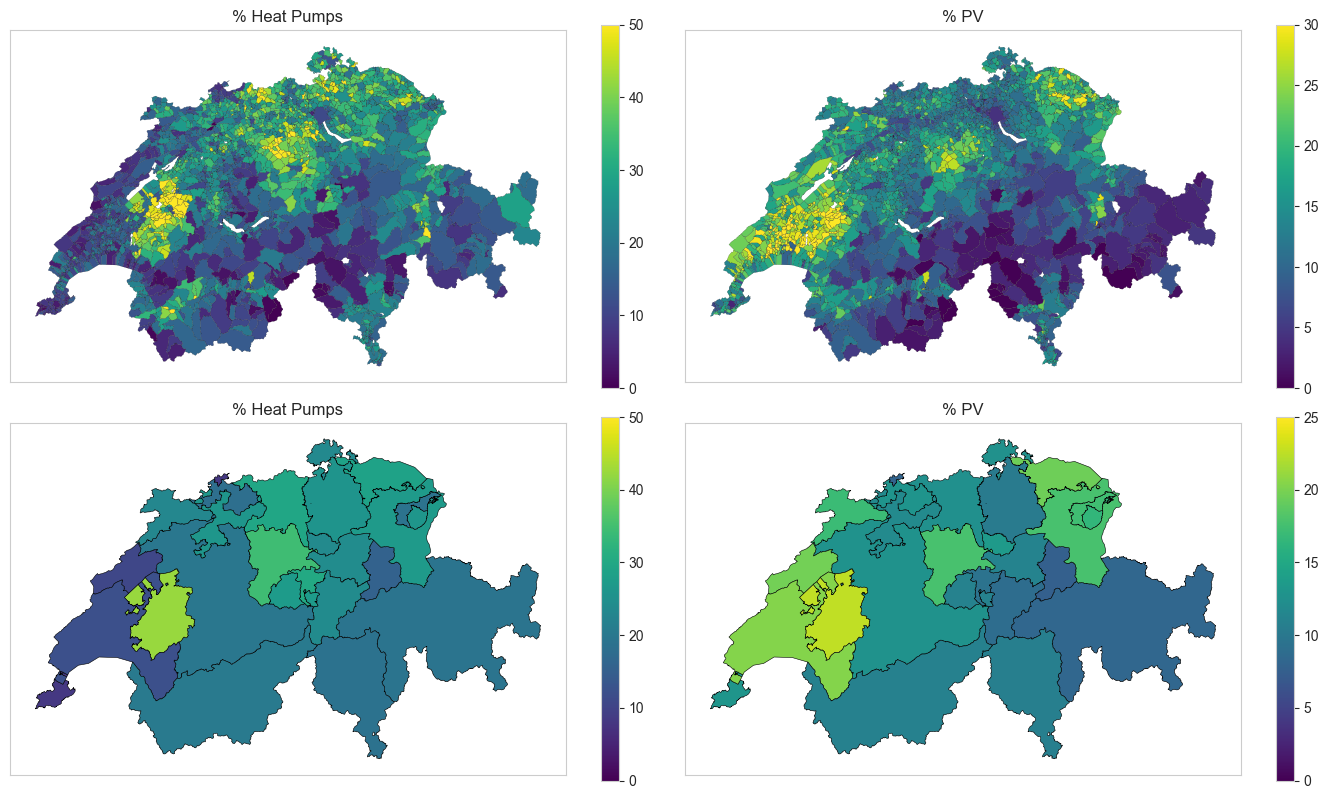

In [32]:
data_m = gdf_2025.pivot_table(index='Municipality', columns='Heating Technology', aggfunc='size', fill_value=0)
data_percentage_m = data_m.div(data_m.sum(axis=1), axis=0) * 100
data_percentage_m = data_percentage_m.reset_index(drop=False)
data_percentage_m = data_percentage_m.merge(municipal_limits, how='left', left_on=['Municipality'], right_on=['NAME'])

data_c = gdf_2025.pivot_table(index='Canton', columns='Heating Technology', aggfunc='size', fill_value=0)
data_percentage_c = data_c.div(data_c.sum(axis=1), axis=0) * 100
data_percentage_c = data_percentage_c.reset_index(drop=False)
data_percentage_c = data_percentage_c.merge(cantonal_limits, how='left', left_on=['Canton'], right_on=['NAME'])

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

data_HP_percentage_m = data_percentage_m[['Municipality', 'HeatPump', 'geometry']]
data_HP_percentage_m = data_HP_percentage_m.reset_index(drop=False)
gdf_HP_m = gpd.GeoDataFrame(data_HP_percentage_m, crs="EPSG:2056", geometry='geometry')
gdf_HP_m.plot(ax=axes[0,0], column='HeatPump', legend=True, linewidth=0.1, vmin=0, vmax=50, edgecolor='black', cmap='viridis').set_title('% Heat Pumps')
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])

data_HP_percentage_c = data_percentage_c[['Canton', 'HeatPump', 'geometry']]
data_HP_percentage_c = data_HP_percentage_c.reset_index(drop=False)
gdf_HP_c = gpd.GeoDataFrame(data_HP_percentage_c, crs="EPSG:2056", geometry='geometry')
gdf_HP_c.plot(ax=axes[1,0], column='HeatPump', legend=True, linewidth=0.4, vmin=0, vmax=50, edgecolor='black', cmap='viridis').set_title('% Heat Pumps')
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])

data_m = gdf_2025.pivot_table(index='Municipality', columns='PV', aggfunc='size', fill_value=0)
data_percentage_m = data_m.div(data_m.sum(axis=1), axis=0) * 100
data_percentage_m = data_percentage_m.reset_index(drop=False)
data_percentage_m = data_percentage_m.merge(municipal_limits, how='left', left_on=['Municipality'], right_on=['NAME'])

data_c = gdf_2025.pivot_table(index='Canton', columns='PV', aggfunc='size', fill_value=0)
data_percentage_c = data_c.div(data_c.sum(axis=1), axis=0) * 100
data_percentage_c = data_percentage_c.reset_index(drop=False)
data_percentage_c = data_percentage_c.merge(cantonal_limits, how='left', left_on=['Canton'], right_on=['NAME'])

data_PV_percentage_m = data_percentage_m[['Municipality', 'PVyes', 'geometry']]
data_PV_percentage_m = data_PV_percentage_m.reset_index(drop=False)
gdf_PV_m = gpd.GeoDataFrame(data_PV_percentage_m, crs="EPSG:2056", geometry='geometry')
gdf_PV_m.plot(ax=axes[0,1], column='PVyes', legend=True, linewidth=0.1, vmin=0, vmax=30, edgecolor='black', cmap='viridis').set_title('% PV')
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])

data_PV_percentage_c = data_percentage_c[['Canton', 'PVyes', 'geometry']]
data_PV_percentage_c = data_PV_percentage_c.reset_index(drop=False)
gdf_PV_c = gpd.GeoDataFrame(data_PV_percentage_c, crs="EPSG:2056", geometry='geometry')
gdf_PV_c.plot(ax=axes[1,1], column='PVyes', legend=True, linewidth=0.4, vmin=0, vmax=25, edgecolor='black', cmap='viridis').set_title('% PV')
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])

plt.tight_layout()
plt.show()

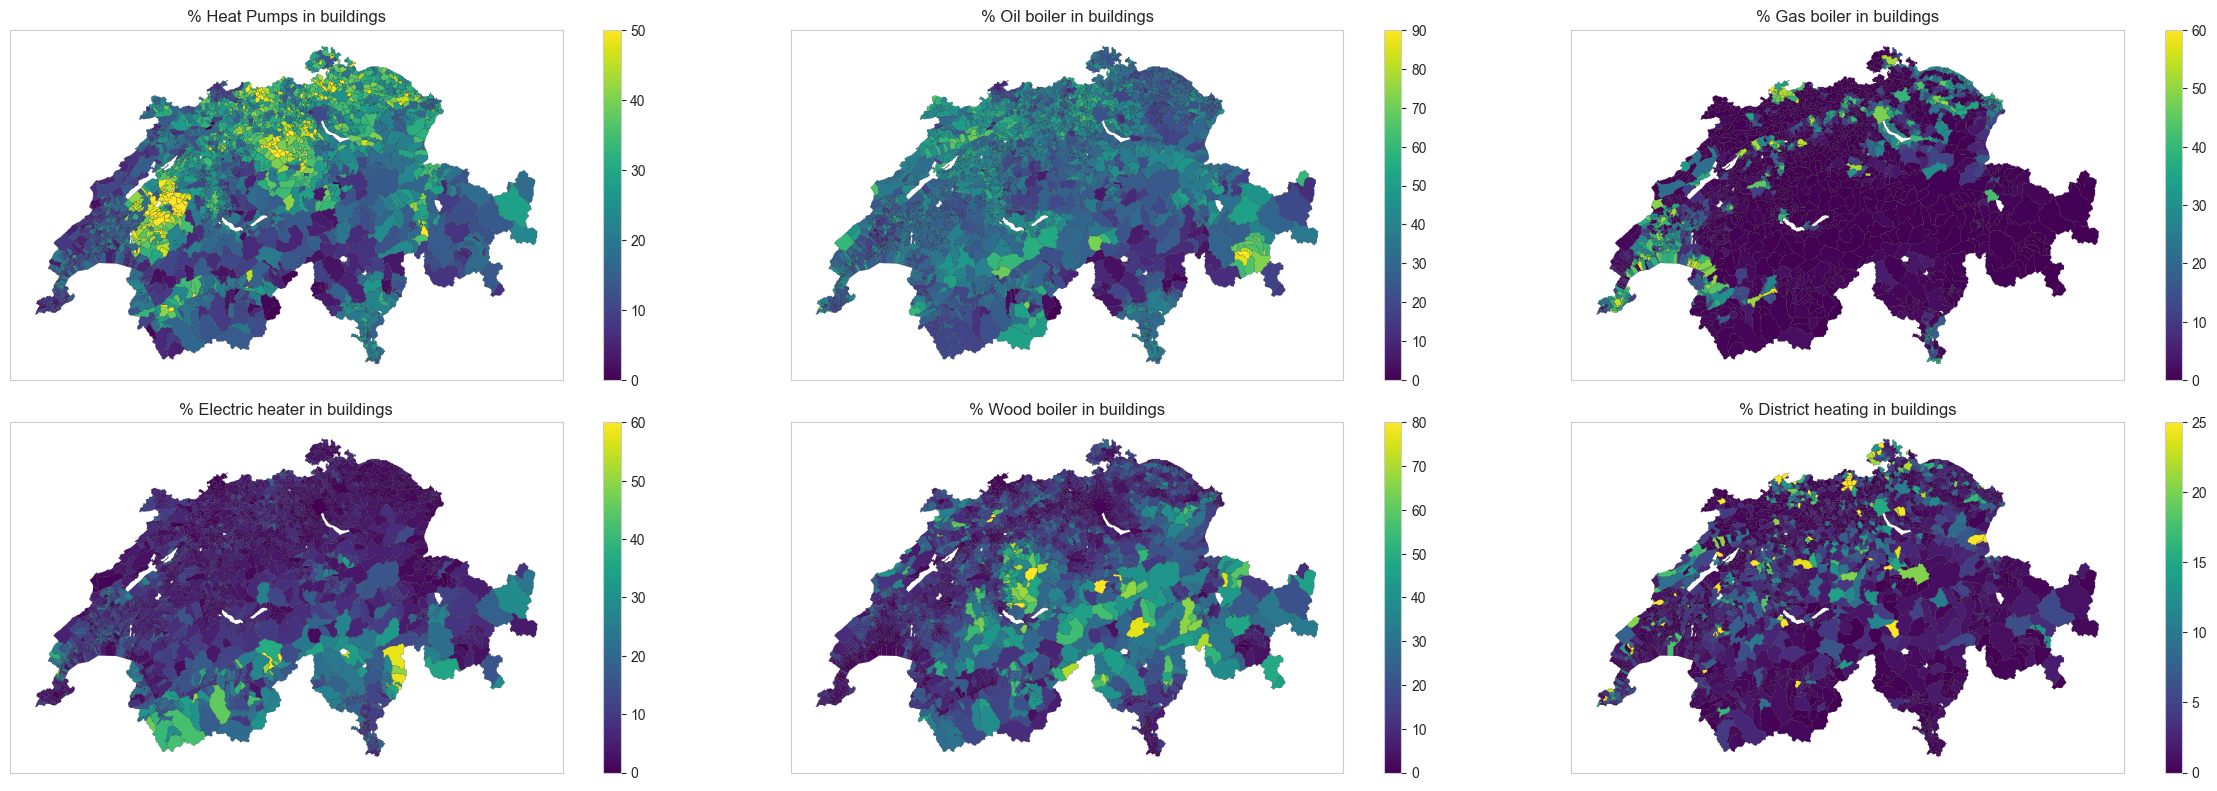

In [37]:
data = gdf_2025.pivot_table(index='Municipality', columns='Heating Technology', aggfunc='size', fill_value=0)
data_percentage = data.div(data.sum(axis=1), axis=0) * 100
data_percentage = data_percentage.reset_index(drop=False)
data_percentage = data_percentage.merge(municipal_limits, how='left', left_on=['Municipality'], right_on=['NAME'])

fig, axes = plt.subplots(2, 3, figsize=(240, 8))

data_HP_percentage = data_percentage[['Municipality', 'HeatPump', 'geometry']]
data_HP_percentage = data_HP_percentage.reset_index(drop=False)
gdf_HP = gpd.GeoDataFrame(data_HP_percentage, crs="EPSG:2056", geometry='geometry')
gdf_HP.plot(ax=axes[0,0], column='HeatPump', legend=True, linewidth=0.1, vmin=0, vmax=50, edgecolor='black', cmap='viridis').set_title('% Heat Pumps in buildings')
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])

data_Oil_percentage = data_percentage[['Municipality', 'Oil', 'geometry']]
data_Oil_percentage = data_Oil_percentage.reset_index(drop=False)
gdf_Oil = gpd.GeoDataFrame(data_Oil_percentage, crs="EPSG:2056", geometry='geometry')
gdf_Oil.plot(ax=axes[0,1], column='Oil', legend=True, linewidth=0.1, vmin=0, vmax=90, edgecolor='black', cmap='viridis').set_title('% Oil boiler in buildings')
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])

data_Gas_percentage = data_percentage[['Municipality', 'Gas', 'geometry']]
data_Gas_percentage = data_Gas_percentage.reset_index(drop=False)
gdf_Gas = gpd.GeoDataFrame(data_Gas_percentage, crs="EPSG:2056", geometry='geometry')
gdf_Gas.plot(ax=axes[0,2], column='Gas', legend=True, linewidth=0.1, vmin=0, vmax=60, edgecolor='black', cmap='viridis').set_title('% Gas boiler in buildings')
axes[0,2].set_xticks([])
axes[0,2].set_yticks([])

data_EH_percentage = data_percentage[['Municipality', 'ElectricHeater', 'geometry']]
data_EH_percentage = data_EH_percentage.reset_index(drop=False)
gdf_EH = gpd.GeoDataFrame(data_EH_percentage, crs="EPSG:2056", geometry='geometry')
gdf_EH.plot(ax=axes[1,0], column='ElectricHeater', legend=True, linewidth=0.1, vmin=0, vmax=60, edgecolor='black', cmap='viridis').set_title('% Electric heater in buildings')
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])

data_Wood_percentage = data_percentage[['Municipality', 'Wood', 'geometry']]
data_Wood_percentage = data_Wood_percentage.reset_index(drop=False)
gdf_Wood = gpd.GeoDataFrame(data_Wood_percentage, crs="EPSG:2056", geometry='geometry')
gdf_Wood.plot(ax=axes[1,1], column='Wood', legend=True, linewidth=0.1, vmin=0, vmax=80, edgecolor='black', cmap='viridis').set_title('% Wood boiler in buildings')
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])

data_DH_percentage = data_percentage[['Municipality', 'DH', 'geometry']]
data_DH_percentage = data_DH_percentage.reset_index(drop=False)
gdf_DH = gpd.GeoDataFrame(data_DH_percentage, crs="EPSG:2056", geometry='geometry')
gdf_DH.plot(ax=axes[1,2], column='DH', legend=True, linewidth=0.1, vmin=0, vmax=25, edgecolor='black', cmap='viridis').set_title('% District heating in buildings')
axes[1,2].set_xticks([])
axes[1,2].set_yticks([])

plt.tight_layout()
plt.show()

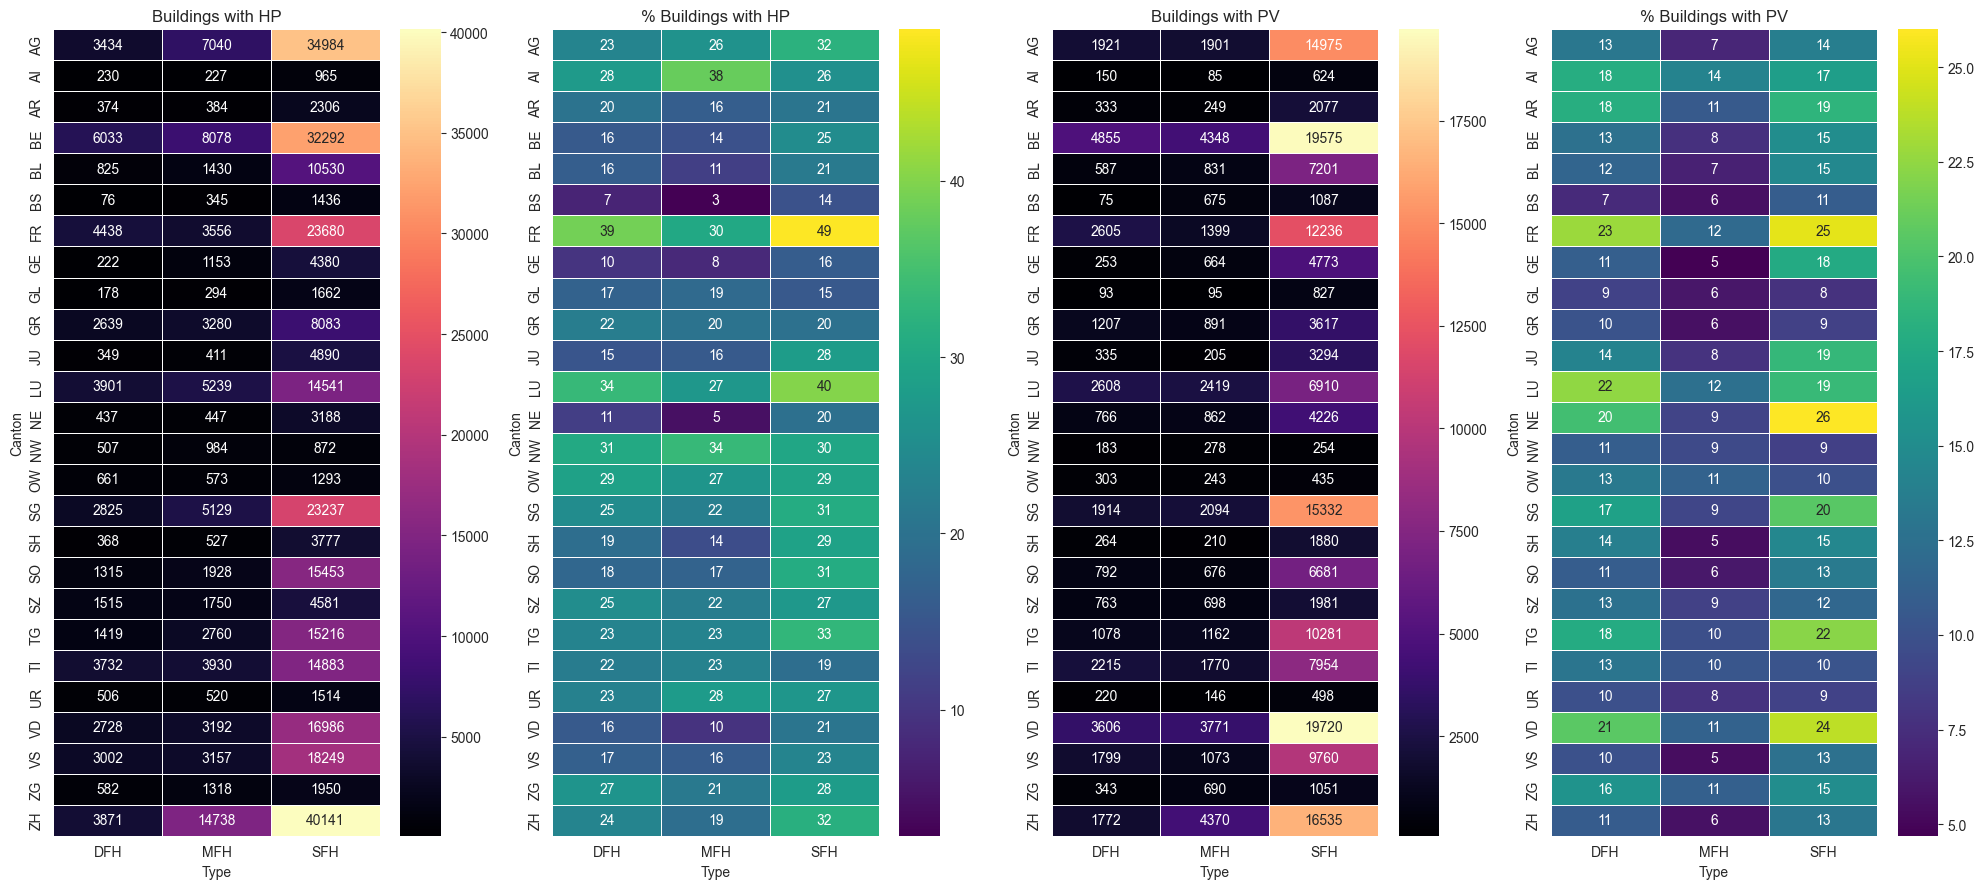

In [34]:
fig, axes = plt.subplots(1, 4, figsize=(20, 9))

gdf_HP = gdf_2025[gdf_2025["Heating Technology"].isin(["HeatPump", 'HPST']) & gdf_2025["Type"].isin(["SFH", 'DFH', 'MFH'])]
data_HP = gdf_HP.pivot_table(index='Canton', columns='Type', aggfunc='size', fill_value=0)
sns.heatmap(data_HP,annot=True, fmt=".0f", cmap='magma', ax=axes[0], cbar=True, linewidth=.5).set_title('Buildings with HP')

data_TOT = gdf_2025[gdf_2025["Type"].isin(["SFH", 'DFH', 'MFH'])].pivot_table(index='Canton', columns='Type', aggfunc='size', fill_value=0)
data_HP_share = data_HP / data_TOT * 100
sns.heatmap(data_HP_share,annot=True, fmt=".0f", cmap='viridis', ax=axes[1], cbar=True, linewidth=.5).set_title('% Buildings with HP')

gdf_PV = gdf_2025[gdf_2025["PV"].isin(["PVyes"]) & gdf_2025["Type"].isin(["SFH", 'DFH', 'MFH'])]
data_PV = gdf_PV.pivot_table(index='Canton', columns='Type', aggfunc='size', fill_value=0)
sns.heatmap(data_PV,annot=True, fmt=".0f", cmap='magma', ax=axes[2], cbar=True, linewidth=.5).set_title('Buildings with PV')

data_PV_share = data_PV / data_TOT * 100
sns.heatmap(data_PV_share,annot=True, fmt=".0f", cmap='viridis', ax=axes[3], cbar=True, linewidth=.5).set_title('% Buildings with PV')

plt.tight_layout()

plt.show()

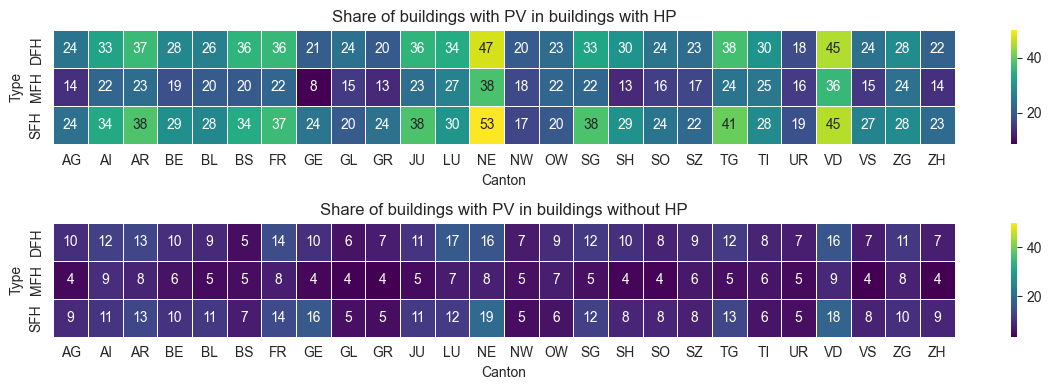

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(12, 4))

gdf_PV_HP = gdf_2025[gdf_2025["PV"].isin(["PVyes"]) & gdf_2025["Type"].isin(["SFH", 'DFH', 'MFH']) & gdf_2025["Heating Technology"].isin(["HeatPump", 'HPST'])]
data_PV_HP = gdf_PV_HP.pivot_table(index='Type', columns='Canton', aggfunc='size', fill_value=0)

data_HP = gdf_HP.pivot_table(index='Type', columns='Canton', aggfunc='size', fill_value=0)

data_PV_share_HP = data_PV_HP / data_HP * 100
sns.heatmap(data_PV_share_HP, annot=True, fmt=".0f", cmap='viridis', ax=axes[0], cbar=True, linewidth=.5, vmax=50)

gdf_PV_no_HP = gdf_2025[gdf_2025["PV"].isin(["PVyes"]) & gdf_2025["Type"].isin(["SFH", 'DFH', 'MFH']) & (~gdf_2025["Heating Technology"].isin(["HeatPump", 'HPST', 'HPOil', 'HPGas']))]
data_PV_no_HP = gdf_PV_no_HP.pivot_table(index='Type', columns='Canton', aggfunc='size', fill_value=0)

gdf_no_HP = gdf_2025[gdf_2025["Type"].isin(["SFH", 'DFH', 'MFH']) & (~gdf_2025["Heating Technology"].isin(["HeatPump", 'HPST']))]
data_no_HP = gdf_no_HP.pivot_table(index='Type', columns='Canton', aggfunc='size', fill_value=0)

data_PV_share_no_HP = data_PV_no_HP / data_no_HP * 100
sns.heatmap(data_PV_share_no_HP, annot=True, fmt=".0f", cmap='viridis', ax=axes[1], cbar=True, linewidth=.5, vmax=50)

axes[0].set_title('Share of buildings with PV in buildings with HP')
axes[1].set_title('Share of buildings with PV in buildings without HP')

plt.tight_layout()

plt.show()

# 4. Regression

## 4.1 Data preparation

In [103]:
gdf_2025_drivers = gdf_2025.copy()

In [104]:
print(len(gdf_2025_drivers))
gdf_2025_drivers = gdf_2025_drivers.loc[~gdf_2025_drivers['Municipality'].isin(['Lema', 'Wachseldorn', 'Grolley-Ponthaux', "C'za Cadenazzo/Monteceneri", 'Laténa', 'Basse-Vendline', 'Augst', 'Reigoldswil', 'Rudolfstetten-Friedlisberg', 'Beinwil (Freiamt)', 'Bourg-Saint-Pierre', 'Liddes', 'Orsières', 'Albula/Alvra', 'Deisswil bei Münchenbuchsee', 'Niederried bei Interlaken', 'Vuisternens-devant-Romont', 'Hergiswil bei Willisau'])].copy()
gdf_2025_drivers = gdf_2025_drivers.loc[~gdf_2025_drivers['Municipality'].isna()].copy()
print(len(gdf_2025_drivers))
gdf_2025_drivers = gdf_2025_drivers.loc[~gdf_2025_drivers['Type'].isin(['No Info'])].copy()
print(len(gdf_2025_drivers))

1718335
1706818
1706152


In [105]:
ev_share_file = '/data/Drivers/share_EVs_mun.csv'

df_ev_share_raw = pd.read_csv(
    notebook_dir + ev_share_file,
    sep=";",
    skiprows=3,
    names=["ID", "Municipality", "EV share [%]"]
)

df_ev_share_raw["EV share [%]"] = pd.to_numeric(df_ev_share_raw["EV share [%]"], errors="coerce")

gdf_2025_drivers = gdf_2025_drivers.merge(
    df_ev_share_raw,
    how="left",
    on="Municipality"
)

_missing = gdf_2025_drivers.loc[gdf_2025_drivers["EV share [%]"].isna(), "Municipality"].unique()
print(f"Municipalities not matched: {len(_missing)}")
print(_missing[:20])

Municipalities not matched: 0
[]


In [106]:
area_categorization_file = '/data/Drivers/area_categotization_mun.xlsx'

df_area_categotization = pd.read_excel(
    notebook_dir + area_categorization_file,
    sheet_name="Dati",
    skiprows=3,
    header=None,
    names=[
        "Municipality Number", "Municipality", "Canton Number", "Canton_raw",
        "District Number","District_raw","Area Type", "Area Category Detail", "Mun_type"
    ],
    dtype=str,
    engine="openpyxl"
)

df_area_categotization = df_area_categotization[["Municipality", "Area Type", "District Number"]].copy()

gdf_2025_drivers = gdf_2025_drivers.merge(
    df_area_categotization,
    how="left",
    on="Municipality"
)

_missing = gdf_2025_drivers.loc[gdf_2025_drivers["Area Type"].isna(), "Municipality"].unique()
print(f"Municipalities not matched: {len(_missing)}")
print(_missing[:20])

Municipalities not matched: 0
[]


In [107]:
unemployment_file = '/data/Drivers/unemployment_rate_district.csv'

df_unemployment = pd.read_csv(
    notebook_dir + unemployment_file,
    sep=",",
    skiprows=1,
    names=["District Number", "District Name", "Unemployment Rate [%]"]
)

gdf_2025_drivers["District Number"] = gdf_2025_drivers["District Number"].astype(int)

gdf_2025_drivers = gdf_2025_drivers.merge(
    df_unemployment,
    how="left",
    on="District Number"
)

canton_means = (
    gdf_2025_drivers
    .groupby("Canton")['Unemployment Rate [%]']
    .transform("mean")
)

gdf_2025_drivers['Unemployment Rate [%]'] = (
    gdf_2025_drivers['Unemployment Rate [%]']
    .fillna(canton_means)
)

_missing = gdf_2025_drivers.loc[gdf_2025_drivers['Unemployment Rate [%]'].isna(), 'Municipality'].unique()
print(f"Municipalities not matched: {len(_missing)}")
print(_missing[:20])

Municipalities not matched: 0
[]


In [108]:
tertiary_edu_file = '/data/Drivers/tertiary_education_share_district.csv'

df_tertiary_edu = pd.read_csv(
    notebook_dir + tertiary_edu_file,
    sep=";",
    skiprows=3,
    names=["District Number", "District Name", "Tertiary Education Rate [%]"]
)

df_tertiary_edu = df_tertiary_edu[[ "District Number", "Tertiary Education Rate [%]"]].copy()

gdf_2025_drivers = gdf_2025_drivers.merge(
    df_tertiary_edu,
    how="left",
    on="District Number"
)

canton_means = (
    gdf_2025_drivers
    .groupby("Canton")['Tertiary Education Rate [%]']
    .transform("mean")
)

gdf_2025_drivers['Tertiary Education Rate [%]'] = (
    gdf_2025_drivers['Tertiary Education Rate [%]']
    .fillna(canton_means)
)

_missing = gdf_2025_drivers.loc[gdf_2025_drivers['Tertiary Education Rate [%]'].isna(), 'Municipality'].unique()
print(f"Municipalities not matched: {len(_missing)}")
print(_missing[:20])

Municipalities not matched: 0
[]


In [109]:
home_ownership_file = '/data/Drivers/home_ownership_rate_can.csv'

df_home_ownership_raw = pd.read_csv(
    notebook_dir + home_ownership_file,
    sep=";",
    skiprows=3,
    names=["ID", "Canton_raw", "Home Ownership Rate [%]"]
)

df_home_ownership_raw["Home Ownership Rate [%]"] = pd.to_numeric(df_home_ownership_raw["Home Ownership Rate [%]"], errors="coerce")
name_to_code = {
    'Zürich': 'ZH', 'Zurigo': 'ZH', 'Zurich': 'ZH',
    'Bern': 'BE', 'Berna': 'BE',
    'Luzern': 'LU', 'Lucerne': 'LU',
    'Uri': 'UR',
    'Schwyz': 'SZ',
    'Obwalden': 'OW',
    'Nidwalden': 'NW',
    'Glarus': 'GL',
    'Zug': 'ZG',
    'Fribourg': 'FR', 'Freiburg': 'FR',
    'Solothurn': 'SO',
    'Basel-Stadt': 'BS',
    'Basel-Landschaft': 'BL',
    'Schaffhausen': 'SH', 'Schaffhouse': 'SH',
    'Appenzell Innerrhoden': 'AI',
    'Appenzell Ausserrhoden': 'AR',
    'St. Gallen': 'SG',
    'Graubünden': 'GR', 'Grigioni': 'GR',
    'Aargau': 'AG',
    'Thurgau': 'TG',
    'Ticino': 'TI', 'Tessin': 'TI',
    'Vaud': 'VD', 'Waadt': 'VD',
    'Valais': 'VS', 'Wallis': 'VS',
    'Neuchâtel': 'NE', 'Neuenburg': 'NE', 'Neuchatel': 'NE',
    'Genève': 'GE', 'Geneva': 'GE', 'Genf': 'GE', 'Geneve': 'GE',
    'Jura': 'JU'
}
df_home_ownership_raw["Canton"] = df_home_ownership_raw["Canton_raw"].map(name_to_code)

_unknown = sorted(df_home_ownership_raw.loc[df_home_ownership_raw["Canton"].isna(), "Canton_raw"].unique())
if _unknown:
    print("Cantons not recognized in CSV:", _unknown)

df_home_ownership = df_home_ownership_raw[["Canton", "Home Ownership Rate [%]"]].dropna(subset=["Canton"]).copy()

gdf_2025_drivers = gdf_2025_drivers.merge(df_home_ownership, on="Canton", how="left")

_missing = gdf_2025_drivers.loc[gdf_2025_drivers['Home Ownership Rate [%]'].isna(), 'Canton'].unique()
_missing = [str(c) for c in _missing if pd.notna(c)]

if _missing:
    print('Missing Home Ownership Rate for cantons:', ', '.join(_missing))
else:
    print('Home Ownership Rate unified for all cantons')

Home Ownership Rate unified for all cantons


In [110]:
second_house_file = '/data/Drivers/secondary_house_rate_mun.gpkg'

gdf_second_house = gpd.read_file(notebook_dir + second_house_file)

df_second_house = (gdf_second_house
               .loc[:, ["Name", "ZWG_3120"]]
               .rename(columns={"Name": "Municipality",
                                "ZWG_3120": "Secondary House Rate [%]"})
              )

gdf_2025_drivers = gdf_2025_drivers.merge(
    df_second_house,
    how="left",
    on="Municipality"
)
_missing = gdf_2025_drivers.loc[gdf_2025_drivers["Secondary House Rate [%]"].isna(), "Municipality"].unique()
print(f"Municipalities not matched: {len(_missing)}")
print(_missing[:20])

Municipalities not matched: 0
[]


In [111]:
people_over65_file = '/data/Drivers/people_over_65_mun.csv'

df_people_over65 = pd.read_csv(
    notebook_dir + people_over65_file,
    sep=";",
    skiprows=3,
    names=["ID", "Municipality", "People Over 65 [%]"]
)

df_people_over65["People Over 65 [%]"] = pd.to_numeric(df_people_over65["People Over 65 [%]"], errors="coerce")

df_people_over65 = df_people_over65[[ "Municipality", "People Over 65 [%]"]].copy()

gdf_2025_drivers = gdf_2025_drivers.merge(
    df_people_over65,
    how="left",
    on="Municipality"
)

_missing = gdf_2025_drivers.loc[gdf_2025_drivers["People Over 65 [%]"].isna(), "Municipality"].unique()
print(f"Municipalities not matched: {len(_missing)}")
print(_missing[:20])

Municipalities not matched: 0
[]


In [112]:
CO2Act_file = '/data/Drivers/CO2Act_yes_mun.csv'

df_CO2Act = pd.read_csv(
    notebook_dir + CO2Act_file,
    sep=";",
    skiprows=3,
    names=["ID", "Municipality", "CO2Act Yes Share [%]"]
)

df_CO2Act["CO2Act Yes Share [%]"] = pd.to_numeric(df_CO2Act["CO2Act Yes Share [%]"], errors="coerce")

df_CO2Act = df_CO2Act[[ "Municipality", "CO2Act Yes Share [%]"]].copy()

gdf_2025_drivers = gdf_2025_drivers.merge(
    df_CO2Act,
    how="left",
    on="Municipality"
)

_missing = gdf_2025_drivers.loc[gdf_2025_drivers["People Over 65 [%]"].isna(), "Municipality"].unique()
print(f"Municipalities not matched: {len(_missing)}")
print(_missing[:20])

Municipalities not matched: 0
[]


In [113]:
electricity_prices_file = '/data/Drivers/electricity_prices_mun.csv'

df_electricity_prices_raw = pd.read_csv(
    notebook_dir + electricity_prices_file,
)

df_electricity_prices = df_electricity_prices_raw[[" operatorLabel"," category"," total (cts./kWh)"]]

df_electricity_prices = df_electricity_prices.rename(columns={
    " operatorLabel":"Operator",
    " category":"Category",
    " total (cts./kWh)":"Electricity Price (cts./kWh)"
})

df_electricity_prices_H2= df_electricity_prices.drop(df_electricity_prices[df_electricity_prices["Category"] != "H2"].index)
df_electricity_prices_H2=df_electricity_prices_H2[["Operator","Electricity Price (cts./kWh)"]]

df_electricity_prices_H2["Electricity Price (cts./kWh)"] = pd.to_numeric(df_electricity_prices_H2["Electricity Price (cts./kWh)"], errors="coerce")

df_electricity_prices_H2_mean = (
    df_electricity_prices_H2
    .groupby("Operator", as_index=False)["Electricity Price (cts./kWh)"]
    .mean()
)

electricity_providers_file = '/data/Drivers/municipality_providers.csv'
df_electricity_providers_raw = pd.read_csv(
    notebook_dir + electricity_providers_file,
)

df_electricity_providers = df_electricity_providers_raw[["operator","municipalityName"]]
df_electricity_providers = df_electricity_providers.rename(columns={
    "operator":"Operator",
    "municipalityName":"Municipality"
})
df_electricity_providers = df_electricity_providers.drop_duplicates(subset="Municipality", keep="first")

gdf_2025_drivers = gdf_2025_drivers.merge(
    df_electricity_providers,
    how="left",
    on="Municipality",
)
gdf_2025_drivers = gdf_2025_drivers.merge(
    df_electricity_prices_H2_mean,
    how="left",
    on="Operator",
)

_missing = gdf_2025_drivers.loc[gdf_2025_drivers["Electricity Price (cts./kWh)"].isna(), "Municipality"].unique()
print(f"Municipalities not matched: {len(_missing)}")
print(_missing[:20])

Municipalities not matched: 0
[]


In [114]:
gdf_2025_drivers["PV_binary"] = gdf_2025_drivers["PV"].map({"PVno": 0, "PVyes": 1})

peer_effect = (
    gdf_2025_drivers
    .groupby("Municipality")["PV_binary"]
    .mean()
    .rename("Peer effect PV municipality")
)

gdf_2025_drivers = gdf_2025_drivers.merge(
    peer_effect,
    on="Municipality",
    how="left"
)

In [115]:
if gdf_2025_drivers.geom_type.isin(["Polygon", "MultiPolygon"]).any():
    gdf_2025_drivers["geometry"] = gdf_2025_drivers.centroid

In [116]:
buffer_dist = 100

gdf_buffers = gdf_2025_drivers.copy()
gdf_buffers["geometry"] = gdf_buffers.geometry.buffer(buffer_dist)

joined = gpd.sjoin(
    gdf_zurich[["geometry"]],
    gdf_2025_drivers[["geometry", "PV_binary"]],
    how="left",
    predicate="intersects"
).rename(columns={"PV_binary": "PV_neighbor"})

peer_local = (
    joined.groupby(joined.index)
    .agg(
        n_buildings=("PV_neighbor", "size"),
        n_pv=("PV_neighbor", "sum")
    )
)

peer_local["Peer effect PV 100m"] = (
    (peer_local["n_pv"] - gdf_2025_drivers["PV_binary"]) /
    (peer_local["n_buildings"] - 1)
)

gdf_2025_drivers = gdf_2025_drivers.join(peer_local["Peer effect PV 100m"])
gdf_2025_drivers['Peer effect PV 100m'] = gdf_2025_drivers['Peer effect PV 100m'].fillna(0)

In [ ]:
buffer_dist = 500

gdf_buffers = gdf_2025_drivers.copy()
gdf_buffers["geometry"] = gdf_buffers.geometry.buffer(buffer_dist)

joined = gpd.sjoin(
    gdf_buffers[["geometry"]],
    gdf_2025_drivers[["geometry", "PV_binary"]],
    how="left",
    predicate="intersects"
).rename(columns={"PV_binary": "PV_neighbor"})

peer_local = (
    joined.groupby(joined.index)
    .agg(
        n_buildings=("PV_neighbor", "size"),
        n_pv=("PV_neighbor", "sum")
    )
)

peer_local["Peer effect PV 500m"] = (
    (peer_local["n_pv"] - gdf_2025_drivers["PV_binary"]) /
    (peer_local["n_buildings"] - 1)
)

gdf_2025_drivers = gdf_2025_drivers.join(peer_local["Peer effect PV 500m"])

In [117]:
gdf_2025_drivers["HP_binary"] = gdf_2025_drivers["Heating Technology"].map({"Oil": 0,
                                                                            "Gas": 0,
                                                                            "Wood": 0,
                                                                            "ElectricHeater": 0,
                                                                            "DH": 0,
                                                                            "No info": 0,
                                                                            "OilST": 0,
                                                                            "GasST": 0,
                                                                            "WoodST": 0,
                                                                            "No heating": 0,
                                                                            "HeatPump": 1,
                                                                            "HPST": 1})

peer_effect = (
    gdf_2025_drivers
    .groupby("Municipality")["HP_binary"]
    .mean()
    .rename("Peer effect HP")
)

gdf_2025_drivers = gdf_2025_drivers.merge(
    peer_effect,
    on="Municipality",
    how="left"
)

In [118]:
gdf_2025_drivers["DH_binary"] = gdf_2025_drivers["Heating Technology"].map({"Oil": 0,
                                                                            "Gas": 0,
                                                                            "Wood": 0,
                                                                            "ElectricHeater": 0,
                                                                            "DH": 1,
                                                                            "No info": 0,
                                                                            "OilST": 0,
                                                                            "GasST": 0,
                                                                            "WoodST": 0,
                                                                            "No heating": 0,
                                                                            "HeatPump": 0,
                                                                            "HPST": 0})

peer_effect = (
    gdf_2025_drivers
    .groupby("Municipality")["DH_binary"]
    .mean()
    .rename("Peer effect DH")
)

gdf_2025_drivers = gdf_2025_drivers.merge(
    peer_effect,
    on="Municipality",
    how="left"
)

## 4.2 Regression analysis

In [119]:
import warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss
from statsmodels.api import Logit, add_constant
from scipy.stats import chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [120]:
gdf_regression = gdf_2025_drivers.drop(columns=['EGID', 'Summer potential [kWh/y]', 'Winter potential [kWh/y]', 'Total potential [kWh/y]', 'geometry', 'Canton', 'Municipality', 'Construction Year', 'xtf_id', 'Heating Technology', 'PV', 'PV power', 'Initial operation Heating', 'Initial operation PV', 'ID', 'District Number', 'District Name', 'Operator', 'DH_binary']).copy()

In [70]:
gdf_regression.columns

Index(['Roof area [m2]', 'Type', 'Construction Period',
       'Specific Roof Potential [kWh/m2y]', 'EV share [%]', 'Area Type',
       'Unemployment Rate [%]', 'Tertiary Education Rate [%]',
       'Home Ownership Rate [%]', 'Secondary House Rate [%]',
       'People Over 65 [%]', 'CO2Act Yes Share [%]',
       'Electricity Price (cts./kWh)', 'PV_binary',
       'Peer effect PV municipality', 'Peer effect PV 100m', 'HP_binary',
       'Peer effect HP', 'Peer effect DH'],
      dtype='object')

In [121]:
if 'Construction Period' in gdf_regression.columns:
    construction_dummies = pd.get_dummies(
        gdf_regression['Construction Period'],
        prefix='ConstrPeriod',
        drop_first=True
    ).astype(int)
    gdf_regression = pd.concat([gdf_regression, construction_dummies], axis=1)
else:
    raise ValueError("Column 'ConstructionPeriod' not found in df_regression_PV.")

In [122]:
if 'Area Type' in gdf_regression.columns:
    construction_dummies = pd.get_dummies(
        gdf_regression['Area Type'],
        prefix='AreaType',
        drop_first=True
    ).astype(int)
    gdf_regression = pd.concat([gdf_regression, construction_dummies], axis=1)
else:
    raise ValueError("Column 'Area Type' not found in df_regression_PV.")

In [123]:
if 'Type' in gdf_regression.columns:
    construction_dummies = pd.get_dummies(
        gdf_regression['Type'],
        prefix='Type',
        drop_first=True
    ).astype(int)
    gdf_regression = pd.concat([gdf_regression, construction_dummies], axis=1)
else:
    raise ValueError("Column 'Type' not found in df_regression_PV.")

In [124]:
def fit_logit(Xmat, yvec, maxiter=500):
    """Fit Logit with intercept; handles empty X (constant only)."""
    Xc = add_constant(Xmat, has_constant='add')
    model = Logit(yvec, Xc).fit(disp=False, maxiter=maxiter)
    return model

In [125]:
def lrt(model_restricted, model_full, df_diff=1):
    """Likelihood Ratio Test: 2*(LL_full - LL_restricted) ~ chi2(df_diff)."""
    D = 2.0 * (model_full.llf - model_restricted.llf)
    p = 1.0 - chi2.cdf(D, df_diff)
    return D, p

### 4.2.1 PV

In [126]:
df_regression_PV = gdf_regression[['Area [m2]', 'Roof area [m2]', 'Type', 'Construction Period', 'Specific Roof Potential [kWh/m2y]', 'EV share [%]', 'Area Type',
                                   'Tertiary Education Rate [%]', 'Home Ownership Rate [%]', 'Secondary House Rate [%]',
                                   'People Over 65 [%]', 'CO2Act Yes Share [%]', 'Electricity Price (cts./kWh)', 'PV_binary', 'Peer effect PV municipality',
                                   'Peer effect PV 100m',
                                   'HP_binary', 'AreaType_2', 'AreaType_3', 'ConstrPeriod_1921-1945', 'ConstrPeriod_1946-1960', 'ConstrPeriod_1961-1970',
                                   'ConstrPeriod_1971-1980', 'ConstrPeriod_1981-1990', 'ConstrPeriod_1991-2000', 'ConstrPeriod_2001-2010',
                                   'ConstrPeriod_> 2010', 'Type_MFH', 'Type_SFH']].copy()

In [127]:
base_predictors = ['Area [m2]', 'Roof area [m2]', 'Specific Roof Potential [kWh/m2y]', 'EV share [%]', 'Tertiary Education Rate [%]', 'Home Ownership Rate [%]', 'Secondary House Rate [%]', 'People Over 65 [%]', 'CO2Act Yes Share [%]', 'Electricity Price (cts./kWh)', 'Peer effect PV 100m', 'HP_binary', 'AreaType_2', 'AreaType_3', 'ConstrPeriod_1921-1945', 'ConstrPeriod_1946-1960', 'ConstrPeriod_1961-1970', 'ConstrPeriod_1971-1980', 'ConstrPeriod_1981-1990', 'ConstrPeriod_1991-2000', 'ConstrPeriod_2001-2010', 'ConstrPeriod_> 2010', 'Type_MFH', 'Type_SFH']

data = df_regression_PV[base_predictors + ['PV_binary']].dropna().copy()
y = data['PV_binary'].astype(int)
X_raw = data.drop(columns=['PV_binary'])

constr_cols = [c for c in X_raw.columns if c.startswith('ConstrPeriod_')]
area_cols = [c for c in X_raw.columns if c.startswith('AreaType_')]
type_cols = [c for c in X_raw.columns if c.startswith('Type_')]


no_scale = ['HP_binary'] + area_cols + constr_cols + type_cols
no_scale = [c for c in no_scale if c in X_raw.columns]
to_scale = [c for c in X_raw.columns if c not in no_scale]


scaler = StandardScaler()
X_std = X_raw.copy()
if to_scale:
    X_std[to_scale] = scaler.fit_transform(X_raw[to_scale])



if X_std.isna().any().any() or y.isna().any():
    raise ValueError("NaN values detected in predictors or target after preprocessing.")

constant_cols = [c for c in X_std.columns if X_std[c].nunique() == 1]
if constant_cols:
    print(f"⚠️ Dropping constant columns: {constant_cols}")
    X_std = X_std.drop(columns=constant_cols)

Xc_test = sm.add_constant(X_std, has_constant='add')
rank = np.linalg.matrix_rank(Xc_test)
if rank < Xc_test.shape[1]:
    print(f"⚠️ Warning: Design matrix not full rank. ({rank}/{Xc_test.shape[1]} independent columns)")
else:
    print("✅ Design matrix full rank (no perfect multicollinearity detected).")

alpha_add = 0.05
remaining = list(X_std.columns)
selected = []

current_model = fit_logit(np.zeros((len(y), 0)), y)  # initial null model

improved = True
while improved and remaining:
    best_p = 1.0
    best_var = None
    best_model = None
    for var in remaining:
        trial_vars = selected + [var]
        try:
            m_full = fit_logit(X_std[trial_vars], y)
            _, p = lrt(current_model, m_full, df_diff=1)
        except Exception:
            continue
        if p < best_p:
            best_p = p
            best_var = var
            best_model = m_full
    if best_var is not None and best_p < alpha_add:
        selected.append(best_var)
        remaining.remove(best_var)
        current_model = best_model
    else:
        improved = False

print(f"[Stepwise] Variables selected ({len(selected)}): {selected}")

if not selected:
    raise RuntimeError("No variable was selected with the set LRT threshold. Try increasing α_add (e.g. 0.05).")

X_tr, X_te, y_tr, y_te = train_test_split(
    X_std[selected], y, test_size=0.20, stratify=y, random_state=0
)

model_final = fit_logit(X_tr, y_tr)

p_te = model_final.predict(add_constant(X_te, has_constant='add')).clip(1e-9, 1 - 1e-9)

auc = roc_auc_score(y_te, p_te)
ll = log_loss(y_te, p_te)
brier = brier_score_loss(y_te, p_te)

print("\n=== PERFORMANCE (Test holdout) ===")
print(f"AUC:       {auc:.3f}")
print(f"LogLoss:   {ll:.3f}")
print(f"Brier:     {brier:.3f}")

print("\n=== MODEL (Train) ===")
print(f"LogLik: {model_final.llf:.1f} | AIC: {model_final.aic:.1f} | BIC: {model_final.bic:.1f}")

pd.set_option('display.max_rows', None)
coef = pd.Series(model_final.params, index=['Intercept'] + selected)
print("\n=== Coefficients (standardized) ===")
print(coef.sort_values())

Xc_vif = add_constant(X_std[selected])
vif_df = pd.DataFrame({
    "Variable": Xc_vif.columns,
    "VIF": [variance_inflation_factor(Xc_vif.values, i) for i in range(Xc_vif.shape[1])]
})
print("\n=== VIF (Variance Inflation Factors) ===")
print(vif_df)

✅ Design matrix full rank (no perfect multicollinearity detected).
[Stepwise] Variables selected (24): ['Area [m2]', 'Roof area [m2]', 'EV share [%]', 'Tertiary Education Rate [%]', 'Home Ownership Rate [%]', 'Secondary House Rate [%]', 'People Over 65 [%]', 'CO2Act Yes Share [%]', 'Electricity Price (cts./kWh)', 'HP_binary', 'Specific Roof Potential [kWh/m2y]', 'AreaType_2', 'AreaType_3', 'ConstrPeriod_1921-1945', 'ConstrPeriod_1946-1960', 'ConstrPeriod_1961-1970', 'ConstrPeriod_1981-1990', 'ConstrPeriod_1991-2000', 'ConstrPeriod_1971-1980', 'ConstrPeriod_2001-2010', 'ConstrPeriod_> 2010', 'Type_MFH', 'Type_SFH', 'Peer effect PV 100m']

=== PERFORMANCE (Test holdout) ===
AUC:       0.722
LogLoss:   0.364
Brier:     0.110

=== MODEL (Train) ===
LogLik: -492204.8 | AIC: 984459.6 | BIC: 984762.5

=== Coefficients (standardized) ===
Type_MFH                            -0.855924
Tertiary Education Rate [%]         -0.173624
Secondary House Rate [%]            -0.171911
Home Ownership Rate 

### 4.2.2 HP

In [128]:
df_regression_HP = gdf_regression[
    ['Area [m2]', 'Type', 'Construction Period', 'EV share [%]', 'Area Type',
     'Tertiary Education Rate [%]', 'Home Ownership Rate [%]', 'Secondary House Rate [%]',
     'People Over 65 [%]', 'CO2Act Yes Share [%]', 'Electricity Price (cts./kWh)', 'PV_binary',
     'HP_binary', 'Peer effect HP', 'Peer effect DH', 'AreaType_2', 'AreaType_3', 'ConstrPeriod_1921-1945', 'ConstrPeriod_1946-1960',
     'ConstrPeriod_1961-1970', 'ConstrPeriod_1971-1980', 'ConstrPeriod_1981-1990', 'ConstrPeriod_1991-2000', 'ConstrPeriod_2001-2010',
     'ConstrPeriod_> 2010', 'Type_MFH', 'Type_SFH']].copy()

In [129]:
base_predictors = [
    'Area [m2]', 'EV share [%]', 'Tertiary Education Rate [%]',
    'Home Ownership Rate [%]', 'Secondary House Rate [%]', 'People Over 65 [%]', 'CO2Act Yes Share [%]', 'Electricity Price (cts./kWh)',
    'PV_binary', 'AreaType_2', 'AreaType_3', 'ConstrPeriod_1921-1945', 'ConstrPeriod_1946-1960', 'ConstrPeriod_1961-1970',
    'ConstrPeriod_1971-1980', 'ConstrPeriod_1981-1990', 'ConstrPeriod_1991-2000', 'ConstrPeriod_2001-2010', 'ConstrPeriod_> 2010',
    'Type_MFH', 'Type_SFH'
]

data = df_regression_HP[base_predictors + ['HP_binary']].dropna().copy()
y = data['HP_binary'].astype(int)
X_raw = data.drop(columns=['HP_binary'])

constr_cols = [c for c in X_raw.columns if c.startswith('ConstrPeriod_')]
area_cols = [c for c in X_raw.columns if c.startswith('AreaType_')]
type_cols = [c for c in X_raw.columns if c.startswith('Type_')]

no_scale = ['PV_binary'] + area_cols + constr_cols + type_cols
no_scale = [c for c in no_scale if c in X_raw.columns]
to_scale = [c for c in X_raw.columns if c not in no_scale]

scaler = StandardScaler()
X_std = X_raw.copy()
if to_scale:
    X_std[to_scale] = scaler.fit_transform(X_raw[to_scale])


if X_std.isna().any().any() or y.isna().any():
    raise ValueError("NaN values detected in predictors or target after preprocessing.")

constant_cols = [c for c in X_std.columns if X_std[c].nunique() == 1]
if constant_cols:
    print(f"⚠️ Dropping constant columns: {constant_cols}")
    X_std = X_std.drop(columns=constant_cols)

Xc_test = sm.add_constant(X_std, has_constant='add')
rank = np.linalg.matrix_rank(Xc_test)
if rank < Xc_test.shape[1]:
    print(f"⚠️ Warning: Design matrix not full rank. ({rank}/{Xc_test.shape[1]} independent columns)")
else:
    print("✅ Design matrix full rank (no perfect multicollinearity detected).")


alpha_add = 0.05
remaining = list(X_std.columns)
selected = []

current_model = fit_logit(np.zeros((len(y), 0)), y)  # initial null model

improved = True
while improved and remaining:
    best_p = 1.0
    best_var = None
    best_model = None
    for var in remaining:
        trial_vars = selected + [var]
        try:
            m_full = fit_logit(X_std[trial_vars], y)
            _, p = lrt(current_model, m_full, df_diff=1)
        except Exception:
            continue
        if p < best_p:
            best_p = p
            best_var = var
            best_model = m_full
    if best_var is not None and best_p < alpha_add:
        selected.append(best_var)
        remaining.remove(best_var)
        current_model = best_model
    else:
        improved = False

print(f"[Stepwise] Variables selected ({len(selected)}): {selected}")

if not selected:
    raise RuntimeError("No variable was selected with the set LRT threshold. Try increasing α_add (e.g. 0.05).")

# Train-test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_std[selected], y, test_size=0.20, stratify=y, random_state=0
)

# Final model
model_final = fit_logit(X_tr, y_tr)

# Predictions
p_te = model_final.predict(add_constant(X_te, has_constant='add')).clip(1e-9, 1 - 1e-9)

# Metrics
auc = roc_auc_score(y_te, p_te)
ll = log_loss(y_te, p_te)
brier = brier_score_loss(y_te, p_te)

print("\n=== PERFORMANCE (Test holdout) ===")
print(f"AUC:       {auc:.3f}")
print(f"LogLoss:   {ll:.3f}")
print(f"Brier:     {brier:.3f}")

print("\n=== MODEL (Train) ===")
print(f"LogLik: {model_final.llf:.1f} | AIC: {model_final.aic:.1f} | BIC: {model_final.bic:.1f}")

# Coefficients
pd.set_option('display.max_rows', None)
coef = pd.Series(model_final.params, index=['Intercept'] + selected)
print("\n=== Coefficients (standardized) ===")
print(coef.sort_values())

Xc_vif = add_constant(X_std[selected])
vif_df = pd.DataFrame({
    "Variable": Xc_vif.columns,
    "VIF": [variance_inflation_factor(Xc_vif.values, i) for i in range(Xc_vif.shape[1])]
})
print("\n=== VIF (Variance Inflation Factors) ===")
print(vif_df)

✅ Design matrix full rank (no perfect multicollinearity detected).
[Stepwise] Variables selected (21): ['Area [m2]', 'EV share [%]', 'Tertiary Education Rate [%]', 'Home Ownership Rate [%]', 'Secondary House Rate [%]', 'People Over 65 [%]', 'CO2Act Yes Share [%]', 'Electricity Price (cts./kWh)', 'PV_binary', 'AreaType_2', 'AreaType_3', 'ConstrPeriod_1921-1945', 'ConstrPeriod_1946-1960', 'ConstrPeriod_1961-1970', 'ConstrPeriod_1971-1980', 'ConstrPeriod_1981-1990', 'ConstrPeriod_1991-2000', 'ConstrPeriod_2001-2010', 'ConstrPeriod_> 2010', 'Type_MFH', 'Type_SFH']

=== PERFORMANCE (Test holdout) ===
AUC:       0.800
LogLoss:   0.436
Brier:     0.138

=== MODEL (Train) ===
LogLik: -586894.6 | AIC: 1173833.1 | BIC: 1174099.7

=== Coefficients (standardized) ===
Type_MFH                       -0.526245
Secondary House Rate [%]       -0.282522
Area [m2]                      -0.145768
Electricity Price (cts./kWh)   -0.096557
CO2Act Yes Share [%]           -0.082888
Tertiary Education Rate [%]  